In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# movie == activity


############## NORMALIZZARE IL DATASET ##############


dataset = pd.read_csv("synthetic-dataset/preference.csv",header=1, names=['user_id', 'movie_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)




# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Need to map movie ID to [1, num_movies], assegna nuovi id ai film per contare numero di film e numero di utenti
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)


print('Number of movies', num_movies)
print('Number of users', num_users)
print(movie_id_to_new_id)

Number of movies 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88, 110.0: 89, 103.0: 90, 35.0: 91, 1.0: 92, 3.0: 93, 0.0: 94, 16.0: 95, 78.0: 96, 75.0: 97

In [3]:
train.head()

,user_id,movie_id,rating
3790,22,56,0.142334
1684,7,39,0.335886
4069,25,23,0.471042
2976,9,1,0.415002
2720,17,36,0.467726


In [4]:
test.head()

,user_id,movie_id,rating
3947,23,45,0.318275
4323,31,71,0.142753
2552,47,55,0.613764
4462,3,51,0.460608
5469,7,8,0.335886


In [5]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

latent_dim = 1 #capire se mettere 1 o 10

# Define inputs
movie_input = Input(shape=[1], name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Visualize the model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#SVG('model.png')

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie-input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding-mlp │ (None, 1, 1)      │        113 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding-mlp  │ (None, 1, 1)      │         51 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-movie-mlp   │ (None, 1)         │          0 │ movie-embedding-… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-user-mlp    │ (None, 1)         │          0 │ user-embedding-m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 2)         │          0 │ flatten-movie-ml… │
│ (Concatenate)       │                   │            │ flatten-user-mlp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2)         │          0 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc-1 (Dense)        │ (None, 100)       │        300 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch-norm-1        │ (None, 100)       │        400 │ fc-1[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100)       │          0 │ batch-norm-1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc-2 (Dense)        │ (None, 50)        │      5,050 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding-mf  │ (None, 1, 1)      │        113 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding-mf   │ (None, 1, 1)      │         51 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch-norm-2        │ (None, 50)        │        200 │ fc-2[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-movie-mf    │ (None, 1)         │          0 │ movie-embedding-… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-user-mf     │ (None, 1)         │          0 │ user-embedding-m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50)        │          0 │ batch-norm-2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,500 (25.39 KB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.3285
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.1529
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.0847
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0587
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0409
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.0410
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.0386
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.0421
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0380
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0403


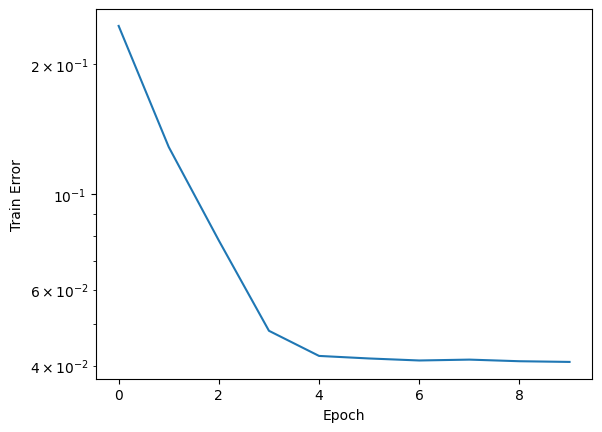

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


0.04327580444943263

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

Conversione

In [8]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/yg/hfdys_9n0rq4w4vtlvtvcvhc0000gn/T/tmpb6tqvkme/assets


INFO:tensorflow:Assets written to: /var/folders/yg/hfdys_9n0rq4w4vtlvtvcvhc0000gn/T/tmpb6tqvkme/assets


: 

In [ ]:
# Caricare il modello TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='model.tflite')

# Allocare i tensori
interpreter.allocate_tensors()

# Ottenere i dettagli degli input e degli output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepara i dati di input per l'inferenza (esempio con un singolo utente e film)
user_id = 1
movie_id = 50#il limite è 50

# Normalizza l'input secondo il modello se necessario (qui l'input è già un array 2D)
input_data = {
    'user-input': np.array([[user_id]], dtype=np.float32),
    'movie-input': np.array([[movie_id]], dtype=np.float32)
}

# Impostare i dati di input
interpreter.set_tensor(input_details[0]['index'], input_data['user-input'])
interpreter.set_tensor(input_details[1]['index'], input_data['movie-input'])

# Eseguire l'inferenza
interpreter.invoke()

# Recuperare i risultati
output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"Predicted rating for user {user_id} and movie {movie_id}: {output_data[0][0]}")

GPU Utilization: only on colab with the selection of the GPU


Performance with svim

In [ ]:
#!pip install pynvml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import GPUtil
import pynvml
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Inizializza NVML
pynvml.nvmlInit()

# Funzione per monitorare l'utilizzo della GPU
def print_gpu_utilization():
    GPUs = GPUtil.getGPUs()
    for gpu in GPUs:
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu.id)
        graphics_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
        sm_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_SM)
        memory_clock = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
        print(f"GPU {gpu.id}: {gpu.name}")
        print(f"  Utilization: {gpu.load*100:.2f}%")
        print(f"  Memory Used: {gpu.memoryUsed} MB")
        print(f"  Memory Total: {gpu.memoryTotal} MB")
        print(f"  Graphics Clock: {graphics_clock} MHz")
        print(f"  SM Clock: {sm_clock} MHz")
        print(f"  Memory Clock: {memory_clock} MHz")

# Funzione per registrare l'utilizzo della GPU durante l'addestramento
def log_gpu_utilization():
    utilization = []
    memory_used = []
    graphics_clocks = []
    sm_clocks = []
    memory_clocks = []
    GPUs = GPUtil.getGPUs()
    for gpu in GPUs:
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu.id)
        utilization.append(gpu.load*100)
        memory_used.append(gpu.memoryUsed)
        graphics_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS))
        sm_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_SM))
        memory_clocks.append(pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM))
    return utilization, memory_used, graphics_clocks, sm_clocks, memory_clocks

# Callback per registrare le metriche della GPU
class GPUUtilizationCallback(Callback):
    def __init__(self):
        super(GPUUtilizationCallback, self).__init__()
        self.gpu_utilization = []
        self.gpu_memory = []
        self.graphics_clocks = []
        self.sm_clocks = []
        self.memory_clocks = []

    def on_epoch_end(self, epoch, logs=None):
        utilization, memory_used, graphics_clocks, sm_clocks, memory_clocks = log_gpu_utilization()
        self.gpu_utilization.append(utilization[0])  # Considera solo la prima GPU
        self.gpu_memory.append(memory_used[0])       # Considera solo la prima GPU
        self.graphics_clocks.append(graphics_clocks[0])
        self.sm_clocks.append(sm_clocks[0])
        self.memory_clocks.append(memory_clocks[0])
        print(f"Epoch {epoch+1} GPU Utilization: {utilization[0]}%, Memory Used: {memory_used[0]}MB")
        print(f"  Graphics Clock: {graphics_clocks[0]} MHz")
        print(f"  SM Clock: {sm_clocks[0]} MHz")
        print(f"  Memory Clock: {memory_clocks[0]} MHz")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Caricamento e pre-elaborazione del dataset
dataset = pd.read_csv("preference.csv", header=1, names=['user_id', 'movie_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)

# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_movies)
print('Number of users', num_users)
print(movie_id_to_new_id)

latent_dim = 1

# Define inputs
movie_input = Input(shape=[1], name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Monitoraggio delle prestazioni della GPU durante l'addestramento
gpu_callback = GPUUtilizationCallback()
train_losses = []
epoch_times = []
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    history = model.fit([train.user_id, train.movie_id], train.rating, epochs=1, verbose=0, callbacks=[gpu_callback])

    end_time = time.time()
    epoch_time = end_time - start_time

    train_losses.append(history.history['loss'][0])
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f} seconds")

# Plotting GPU utilization
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.gpu_utilization, marker='o')
plt.title('GPU Utilization Over Time')
plt.xlabel('Epoch')
plt.ylabel('Utilization (%)')
plt.grid(True)
plt.show()

# Plotting GPU memory usage
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.gpu_memory, marker='o')
plt.title('GPU Memory Usage Over Time')
plt.xlabel('Epoch')
plt.ylabel('Memory Used (MB)')
plt.grid(True)
plt.show()

# Plotting GPU graphics clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.graphics_clocks, marker='o')
plt.title('GPU Graphics Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('Graphics Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting GPU SM clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.sm_clocks, marker='o')
plt.title('GPU SM Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('SM Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting GPU memory clock speed
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), gpu_callback.memory_clocks, marker='o')
plt.title('GPU Memory Clock Over Time')
plt.xlabel('Epoch')
plt.ylabel('Memory Clock (MHz)')
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# Plotting epoch times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_times, marker='o')
plt.title('Epoch Time Over Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
print("Mean Absolute Error:", mean_absolute_error(y_true, y_hat))

# Cleanup NVML
pynvml.nvmlShutdown()


Performance CPU

Number of movies 112
Number of users 50
{73.0: 1, 8.0: 2, 69.0: 3, 81.0: 4, 102.0: 5, 83.0: 6, 45.0: 7, 80.0: 8, 29.0: 9, 11.0: 10, 98.0: 11, 18.0: 12, 63.0: 13, 48.0: 14, 101.0: 15, 47.0: 16, 52.0: 17, 92.0: 18, 65.0: 19, 25.0: 20, 85.0: 21, 31.0: 22, 49.0: 23, 99.0: 24, 58.0: 25, 86.0: 26, 10.0: 27, 33.0: 28, 67.0: 29, 38.0: 30, 26.0: 31, 109.0: 32, 37.0: 33, 23.0: 34, 88.0: 35, 64.0: 36, 77.0: 37, 17.0: 38, 7.0: 39, 56.0: 40, 76.0: 41, 39.0: 42, 96.0: 43, 84.0: 44, 4.0: 45, 105.0: 46, 6.0: 47, 27.0: 48, 53.0: 49, 70.0: 50, 106.0: 51, 61.0: 52, 24.0: 53, 90.0: 54, 51.0: 55, 79.0: 56, 72.0: 57, 36.0: 58, 89.0: 59, 95.0: 60, 74.0: 61, 13.0: 62, 30.0: 63, 44.0: 64, 87.0: 65, 97.0: 66, 32.0: 67, 59.0: 68, 21.0: 69, 14.0: 70, 40.0: 71, 68.0: 72, 93.0: 73, 9.0: 74, 71.0: 75, 91.0: 76, 20.0: 77, 100.0: 78, 66.0: 79, 108.0: 80, 34.0: 81, 46.0: 82, 57.0: 83, 2.0: 84, 22.0: 85, 82.0: 86, 15.0: 87, 60.0: 88, 110.0: 89, 103.0: 90, 35.0: 91, 1.0: 92, 3.0: 93, 0.0: 94, 16.0: 95, 78.0: 96, 75.0: 97

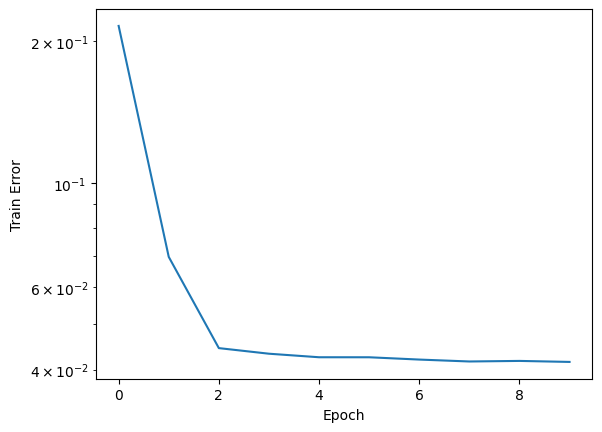

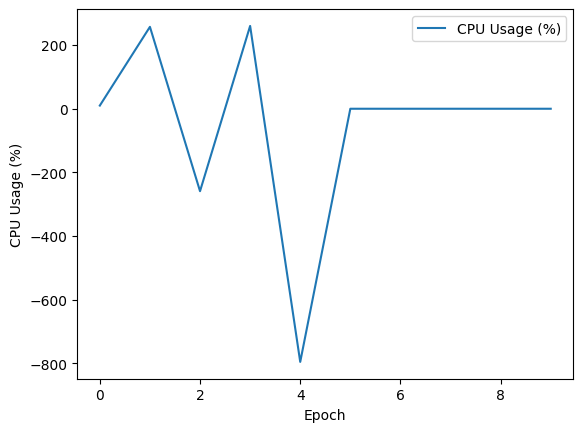

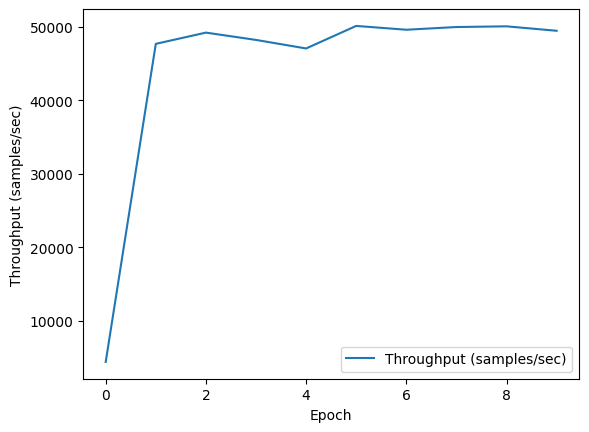

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
Mean Absolute Error: 0.04060691078066592


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import psutil
import time

# movie == activity

############## NORMALIZZARE IL DATASET ##############

dataset = pd.read_csv("synthetic-dataset/preference.csv", header=1, names=['user_id', 'movie_id', 'rating'])

# Replace -1 with NaN to indicate missing data
dataset.replace(-1, np.nan, inplace=True)

# Calcola la media delle preferenze per ogni utente
mean_user_preferences = dataset.groupby('user_id')['rating'].transform('mean')

# Sostituisci i NaN con la media calcolata per ciascun utente
dataset['rating'] = dataset['rating'].fillna(mean_user_preferences)

# Mischiare i dati
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Need to map movie ID to [1, num_movies], assegna nuovi id ai film per contare numero di film e numero di utenti
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_movies)
print('Number of users', num_users)
print(movie_id_to_new_id)

from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

latent_dim = 1  # capire se mettere 1 o 10

# Define inputs
movie_input = Input(shape=[1], name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Variables to store CPU usage and throughput per epoch
cpu_usage = []
throughput = []

class PerformanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.cpu_end = psutil.cpu_percent(interval=None)
        cpu_used = (self.cpu_end - self.cpu_start) / elapsed_time
        samples_per_sec = len(train) / elapsed_time

        cpu_usage.append(cpu_used)
        throughput.append(samples_per_sec)

        print(f"Epoch {epoch + 1}: CPU Usage: {cpu_used:.2f}%, Throughput: {samples_per_sec:.2f} samples/sec")

performance_callback = PerformanceCallback()
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10, callbacks=[performance_callback])

# Plot training error
plt.figure()
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Plot CPU usage
plt.figure()
plt.plot(cpu_usage, label='CPU Usage (%)')
plt.xlabel("Epoch")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.show()

# Plot throughput
plt.figure()
plt.plot(throughput, label='Throughput (samples/sec)')
plt.xlabel("Epoch")
plt.ylabel("Throughput (samples/sec)")
plt.legend()
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
print("Mean Absolute Error:", mean_absolute_error(y_true, y_hat))
